In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load benchmark data from CSV files
cpu_benchmark_data = pd.read_csv('cpu_benchmark_results.csv')
gpu_benchmark_data = pd.read_csv('gpu_benchmark_result.csv')
qe_tsm_benchmark_data = pd.read_csv('qe_tsm_benchmark_results.csv')
quantum_benchmark_data = pd.read_csv('quantum_benchmark_results.csv')

In [17]:
qe_tsm_benchmark_data.head()
quantum_benchmark_data.head()

,Run,N,CUDA-Q Target,Shots,BF-DCQO Iters,Theta Cutoff,Alpha,Kappa,T,Trotter Steps,...,MTS p_mutate,MTS tabu_steps,MTS tabu_tenure,Best E,Q Sample Time,MTS Conv. Time,Total Time,Merit F.,Generations,Sequence
12,1,13,NaN,1000,7,0.04,0.01,5.0,1.0,100,...,0.02,60,10,6,0.192590,0.071728,3.43681,14.08330,1000,-----++--+-+-
14,1,15,NaN,1000,7,0.04,0.01,5.0,1.0,100,...,0.02,60,10,15,0.304385,0.168168,3.87691,7.50000,1000,-----++--++-+-+
15,1,16,NaN,1000,7,0.04,0.01,5.0,1.0,100,...,0.02,60,10,24,0.376105,0.018968,4.10324,5.33333,1000,++------+-+--++-
16,1,17,NaN,1000,7,0.04,0.01,5.0,1.0,100,...,0.02,60,10,32,0.480661,0.004157,4.35606,4.51562,1000,++-+-+--+--++----
17,1,18,NaN,1000,7,0.04,0.01,5.0,1.0,100,...,0.02,60,10,25,0.484517,0.004328,4.57251,6.48000,1000,+--++-++++----+-+-


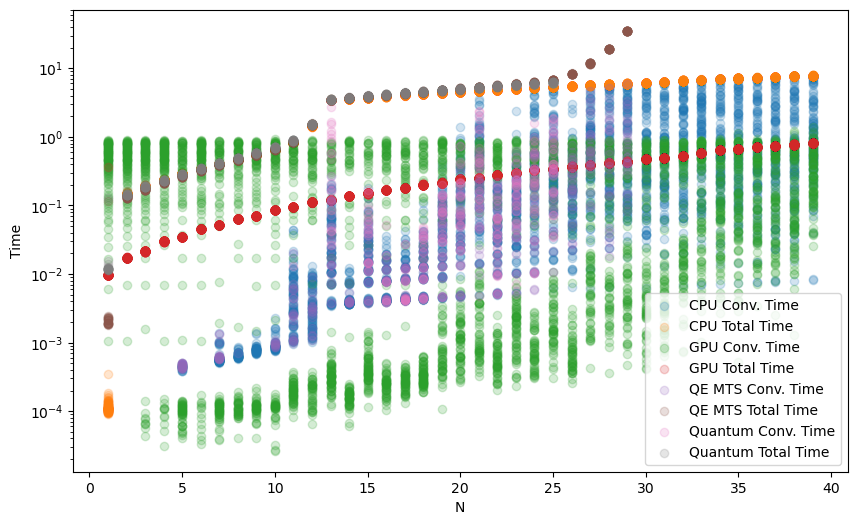

In [5]:
# plot the median convergence time and total time for each N
plt.figure(figsize=(10, 6))
plt.scatter(cpu_benchmark_data['N'], cpu_benchmark_data['Conv. Time'], label='CPU Conv. Time', alpha=0.2)
plt.scatter(cpu_benchmark_data['N'], cpu_benchmark_data['Total Time'], label='CPU Total Time', alpha=0.2)
plt.scatter(gpu_benchmark_data['N'], gpu_benchmark_data['Conv. Time'], label='GPU Conv. Time', alpha=0.2)
plt.scatter(gpu_benchmark_data['N'], gpu_benchmark_data['Total Time'], label='GPU Total Time', alpha=0.2)
plt.scatter(qe_tsm_benchmark_data['N'], qe_tsm_benchmark_data['MTS Conv. Time'], label='QE MTS Conv. Time', alpha=0.2)
plt.scatter(qe_tsm_benchmark_data['N'], qe_tsm_benchmark_data['Total Time'], label='QE MTS Total Time', alpha=0.2)
plt.scatter(quantum_benchmark_data['N'], quantum_benchmark_data['MTS Conv. Time'], label='Quantum Conv. Time', alpha=0.2)
plt.scatter(quantum_benchmark_data['N'], quantum_benchmark_data['Total Time'], label='Quantum Total Time', alpha=0.2)
plt.xlabel('N')
plt.ylabel('Time')
plt.yscale('log')
plt.legend()
plt.show()

In [6]:
# find median convergence time and total time for each N
cpu_median_conv_time = cpu_benchmark_data.groupby('N')['Conv. Time'].median()
gpu_median_conv_time = gpu_benchmark_data.groupby('N')['Conv. Time'].median()
qe_tsm_median_conv_time = qe_tsm_benchmark_data.groupby('N')['MTS Conv. Time'].median()
quantum_median_conv_time = quantum_benchmark_data.groupby('N')['MTS Conv. Time'].median()

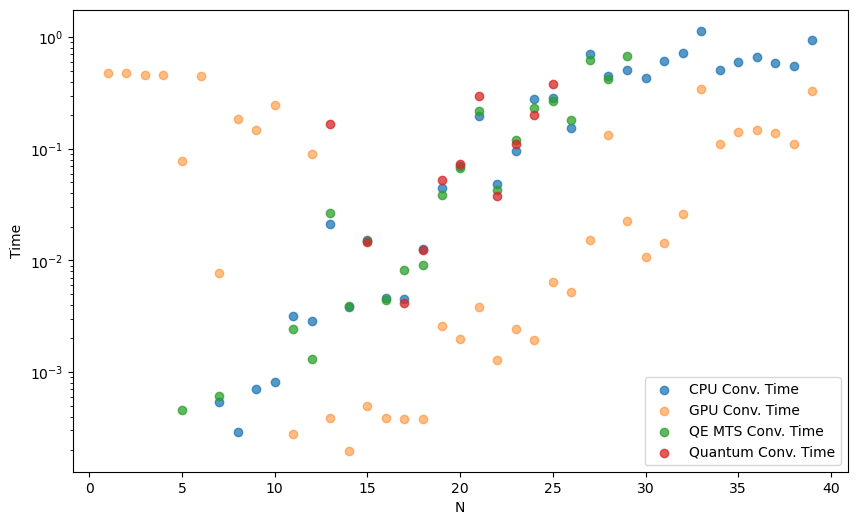

In [7]:
# plot the median convergence time and total time for each N
plt.figure(figsize=(10, 6))
plt.scatter(cpu_median_conv_time.index, cpu_median_conv_time, label='CPU Conv. Time', alpha=0.75)
plt.scatter(gpu_median_conv_time.index, gpu_median_conv_time, label='GPU Conv. Time', alpha=0.5)
plt.scatter(qe_tsm_median_conv_time.index, qe_tsm_median_conv_time, label='QE MTS Conv. Time', alpha=0.75)
plt.scatter(quantum_median_conv_time.index, quantum_median_conv_time, label='Quantum Conv. Time', alpha=0.75)
plt.xlabel('N')
plt.ylabel('Time')
plt.yscale('log')
plt.legend()
plt.show()

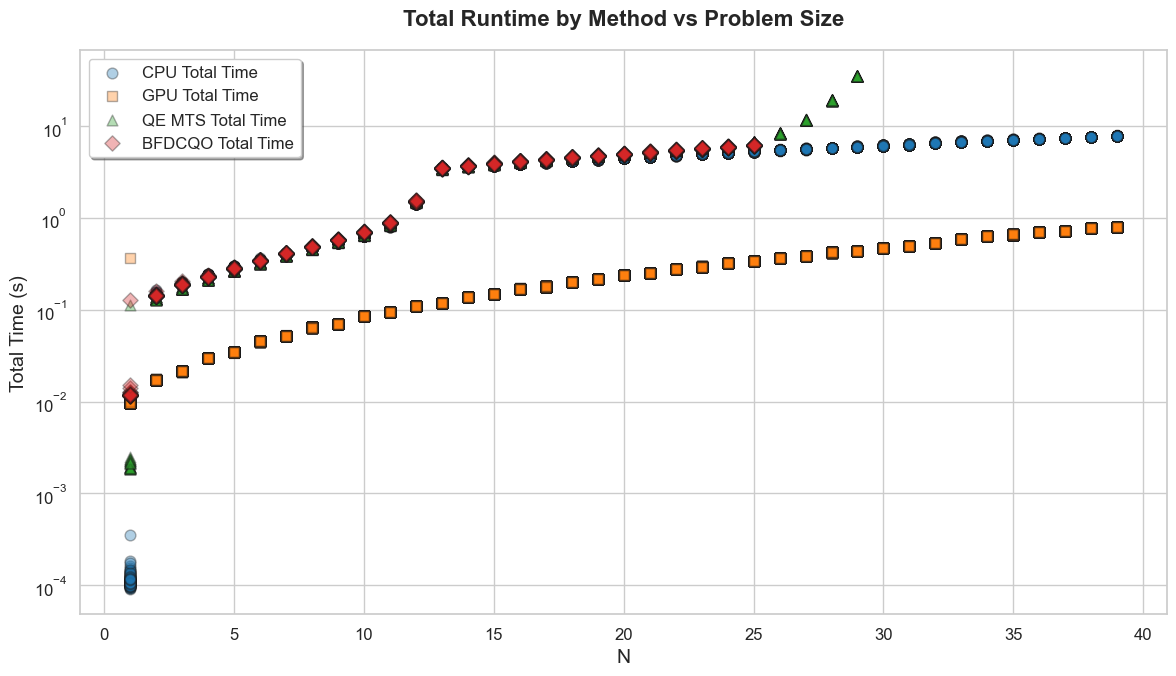

In [8]:
# Enhanced, more aesthetic plot for total time vs N

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.set(style="whitegrid", font_scale=1.2)

# Colors and markers for each method
styles = [
    {'color': 'tab:blue',     'marker': 'o', 'label': 'CPU Total Time'},
    {'color': 'tab:orange',   'marker': 's', 'label': 'GPU Total Time'},
    {'color': 'tab:green',    'marker': '^', 'label': 'QE MTS Total Time'},
    {'color': 'tab:red',      'marker': 'D', 'label': 'BFDCQO Total Time'},
]
datas = [
    (cpu_benchmark_data, 'N', 'Total Time'),
    (gpu_benchmark_data, 'N', 'Total Time'),
    (qe_tsm_benchmark_data, 'N', 'Total Time'),
    (quantum_benchmark_data, 'N', 'Total Time'),
]

# Plot each dataset with unique style
for style, (df, n_col, t_col) in zip(styles, datas):
    plt.scatter(
        df[n_col], df[t_col],
        c=style['color'],
        marker=style['marker'],
        edgecolor='k',
        s=60,
        alpha=0.35,
        label=style['label']
    )

plt.xlabel('N', fontsize=14)
plt.ylabel('Total Time (s)', fontsize=14)
plt.yscale('log')
plt.title('Total Runtime by Method vs Problem Size', fontsize=16, fontweight='bold', pad=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=12, frameon=True, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

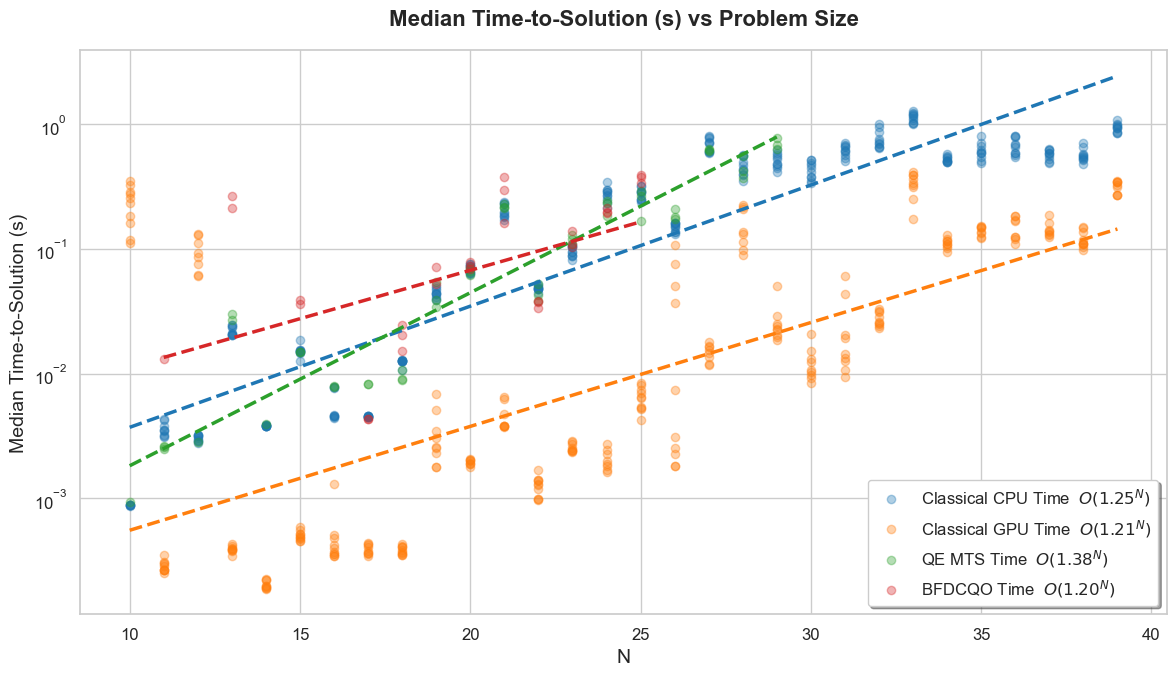

In [20]:
# More aesthetic plot: Regression on medians, showing mid 50 percentile of times for each method and N
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.set(style="whitegrid", font_scale=1.2)

def clean_conv_time(df, time_columns):
    """
    Remove rows with NaN, inf, or zero convergence times.
    Modifies df in place (for dropna).
    """
    for col in time_columns:
        if col in df.columns:
            df.dropna(subset=[col], inplace=True)
            df = df[np.isfinite(df[col])]
            df = df[df[col] > 0]
    return df

cpu_benchmark_data = clean_conv_time(cpu_benchmark_data, ['Conv. Time'])
gpu_benchmark_data = clean_conv_time(gpu_benchmark_data, ['Conv. Time'])
qe_tsm_benchmark_data = clean_conv_time(qe_tsm_benchmark_data, ['MTS Conv. Time'])
quantum_benchmark_data = clean_conv_time(quantum_benchmark_data, ['MTS Conv. Time'])

styles = [
    {'color': 'tab:blue',   'label': 'Classical CPU Time',    'data': cpu_benchmark_data,      'conv_col': 'Conv. Time'},
    {'color': 'tab:orange', 'label': 'Classical GPU Time',    'data': gpu_benchmark_data,      'conv_col': 'Conv. Time'},
    {'color': 'tab:green',  'label': 'QE MTS Time', 'data': qe_tsm_benchmark_data,   'conv_col': 'MTS Conv. Time'},
    {'color': 'tab:red',    'label': 'BFDCQO Time', 'data': quantum_benchmark_data,  'conv_col': 'MTS Conv. Time'},
]

# Store the O(alpha^N) growth string for the legend
growth_legend_entries = []

for style in styles:
    data = style['data']
    conv_col = style['conv_col']

    # Only consider N >= 10
    filtered = data[data['N'] >= 10].copy()
    if conv_col not in filtered.columns or filtered.empty:
        continue

    # Compute mid 50% quantiles and medians grouped by N
    q25 = filtered.groupby('N')[conv_col].quantile(0.45)
    q75 = filtered.groupby('N')[conv_col].quantile(0.55)
    med = filtered.groupby('N')[conv_col].median()

    # Show only the mid 50% data cloud for aesthetic clarity
    mask = filtered.apply(
        lambda row: row[conv_col] >= q25.loc[row['N']] and row[conv_col] <= q75.loc[row['N']], axis=1
    )
    mid50 = filtered[mask]

    # Regression on medians
    xs = med.index.values
    ys = med.values
    mask_finite = np.isfinite(xs) & np.isfinite(ys) & (ys > 0)
    xs = xs[mask_finite]
    ys = ys[mask_finite]

    fit_alpha = None  # To be filled with O(alpha^n) value
    legend_label = style['label']

    if len(xs) > 0 and np.all(ys > 0) and np.isfinite(np.log(ys)).all():
        def log_exp_model(N, log_a, log_alpha):
            return log_a + N * log_alpha
        try:
            popt, _ = curve_fit(log_exp_model, xs, np.log(ys), p0=[-5, 0.2])
            log_a, log_alpha = popt
            a = np.exp(log_a)
            alpha = np.exp(log_alpha)
            fit_alpha = alpha
            N_fit = np.linspace(xs.min(), xs.max(), 150)
            y_fit = a * (alpha ** N_fit)
            plt.plot(
                N_fit, y_fit, color=style['color'], linewidth=2.5, linestyle='--'
            )
        except Exception as e:
            print(f"Fit failed for {style['label']}: {e}")

    # Format the dot/scatter legend entry with O(alpha^n) if fit succeeded
    if fit_alpha is not None:
        # Use 3 significant digits for alpha
        alpha_disp = np.format_float_positional(fit_alpha, precision=3, unique=False, fractional=False, trim='k')
        dot_label = f"{legend_label}  $O({alpha_disp}^N)$"
    else:
        dot_label = legend_label

    growth_legend_entries.append({'scatter_args': {
        'c': style['color'], 'alpha': 0.35, 's': 36, 'label': dot_label},
        'N': mid50['N'], 'TTS': mid50[conv_col]})

# Actually plot each dataset's dots and collect handles
scatter_handles = []
for entry in growth_legend_entries:
    handle = plt.scatter(
        entry['N'], entry['TTS'], **entry['scatter_args']
    )
    scatter_handles.append(handle)
# N.B. regression curves already drawn above as dashed lines of same color

plt.xlabel('N', fontsize=14)
plt.ylabel('Median Time-to-Solution (s)', fontsize=14)
plt.yscale('log')
plt.title('Median Time-to-Solution (s) vs Problem Size', fontsize=16, fontweight='bold', pad=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=12, frameon=True, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()


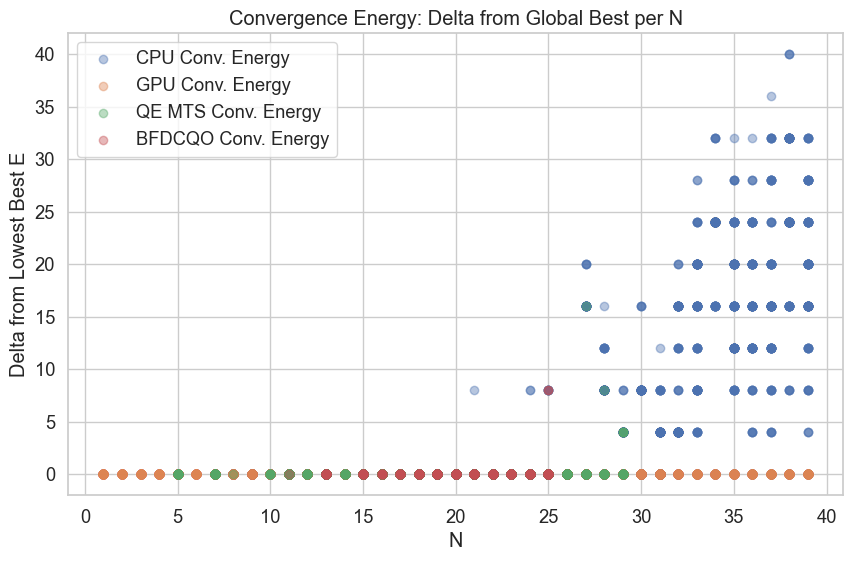

In [18]:
# Plot the delta from each benchmark's "Best E" to the lowest achieved "Best E" at each N

plt.figure(figsize=(10, 6))

datasets = {
    'CPU Conv. Energy': cpu_benchmark_data,
    'GPU Conv. Energy': gpu_benchmark_data,
    'QE MTS Conv. Energy': qe_tsm_benchmark_data,
    'BFDCQO Conv. Energy': quantum_benchmark_data
}

# Collect all data into a single DataFrame for lowest Best E per N
import pandas as pd

dfs = []
for label, df in datasets.items():
    temp = df.copy()
    temp['Source'] = label
    dfs.append(temp)
all_data = pd.concat(dfs, ignore_index=True)

# Compute the lowest "Best E" for each N across all datasets
lowest_best_e_per_n = all_data.groupby('N')['Best E'].min()

# Plot delta from the best for each data source
for label, df in datasets.items():
    # Ensure matching by N
    df = df.copy()
    df['Delta E'] = df.apply(lambda row: row['Best E'] - lowest_best_e_per_n.loc[row['N']], axis=1)
    plt.scatter(df['N'], df['Delta E'], label=label, alpha=0.4)

plt.xlabel('N')
plt.ylabel('Delta from Lowest Best E')
plt.legend()
plt.title('Convergence Energy: Delta from Global Best per N')
plt.show()


/var/folders/2f/cvmbnp4s1r362w323xc1fx800000gn/T/ipykernel_5759/549336905.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


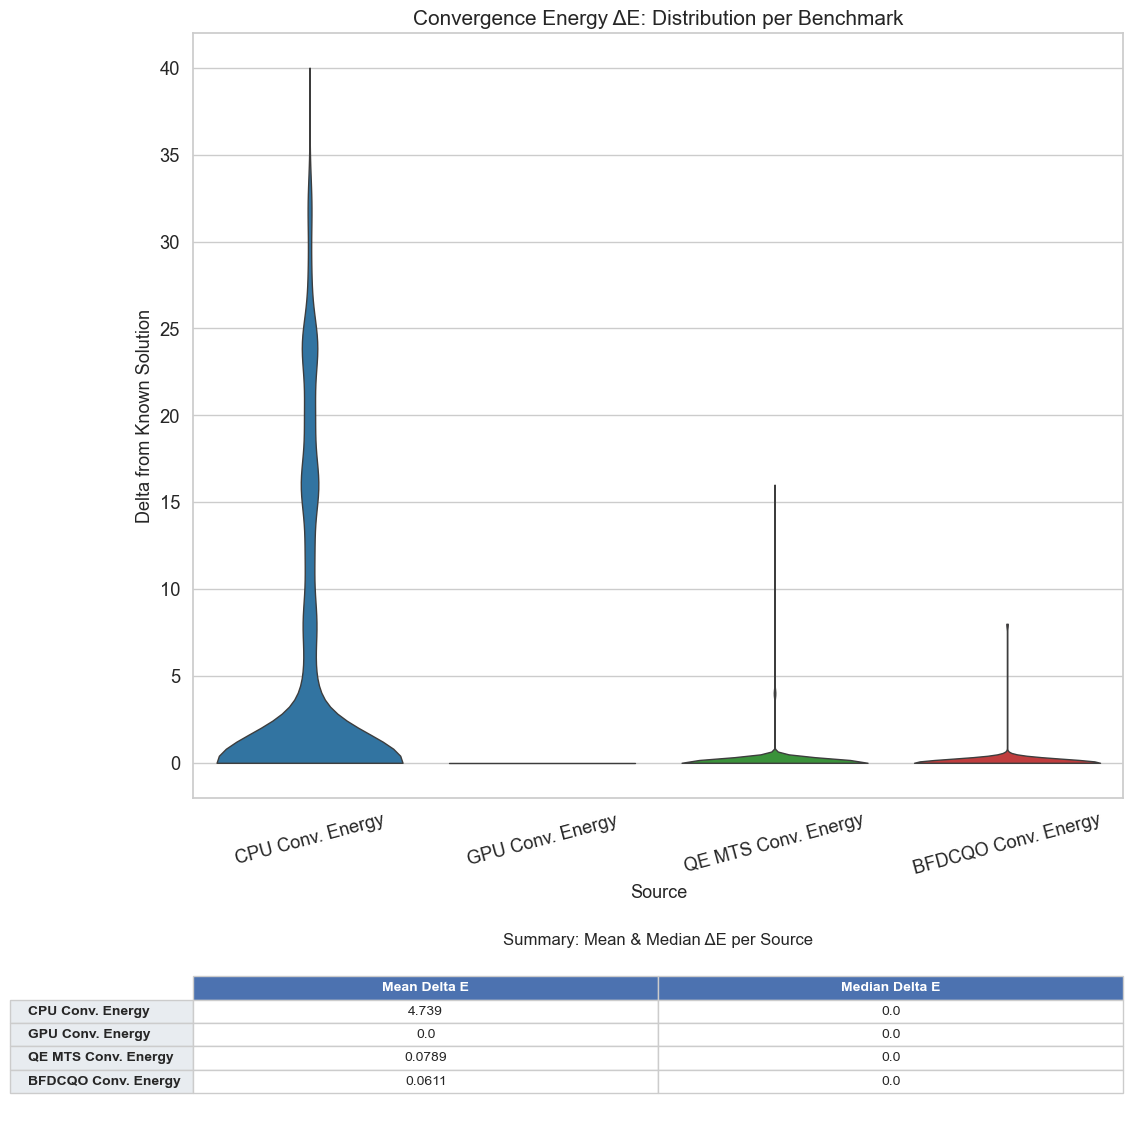

In [19]:
import seaborn as sns
import matplotlib.gridspec as gridspec

# Calculate mean and median deviation (Delta E) for each source
deviation_stats = {}

# Gather per-sample Delta E values for all datasets
delta_e_long_df = []
for label, df in datasets.items():
    temp_df = df.copy()
    temp_df['Delta E'] = temp_df.apply(lambda row: row['Best E'] - lowest_best_e_per_n.loc[row['N']], axis=1)
    temp_df['Source'] = label
    deviation_stats[label] = {
        'Mean Delta E': temp_df['Delta E'].mean(),
        'Median Delta E': temp_df['Delta E'].median()
    }
    delta_e_long_df.append(temp_df[['N', 'Delta E', 'Source']])
delta_e_long_df = pd.concat(delta_e_long_df, ignore_index=True)

# --- Combined figure: violin+swarm on top, summary table on bottom ---
fig = plt.figure(figsize=(12, 14))
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.35)

# --- Top: Violin + Swarm ---
ax1 = fig.add_subplot(gs[0])

sns.violinplot(
    data=delta_e_long_df,
    x='Source',
    y='Delta E',
    hue='Source',          # ← added
    legend=False,          # ← added
    inner=None,
    linewidth=1,
    cut=0,
    palette='tab10',
    ax=ax1
)

ax1.set_xlabel('Source', fontsize=13)
ax1.set_ylabel('Delta from Known Solution', fontsize=13)
ax1.set_title('Convergence Energy ΔE: Distribution per Benchmark', fontsize=15)
ax1.tick_params(axis='x', rotation=15)

# --- Bottom: Summary Table ---
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')

summary_table = pd.DataFrame(deviation_stats).T[['Mean Delta E', 'Median Delta E']].round(4)

table = ax2.table(
    cellText=summary_table.values,
    colLabels=summary_table.columns,
    rowLabels=summary_table.index,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.4)                  # row height
for key, cell in table.get_celld().items():
    cell.set_edgecolor('#cccccc')
    if key[0] == 0:                  # header row
        cell.set_facecolor('#4c72b0')
        cell.set_text_props(color='white', fontweight='bold')
    elif key[1] == -1:               # row labels
        cell.set_facecolor('#e8ecf0')
        cell.set_text_props(fontweight='bold')
    else:
        cell.set_facecolor('white')

ax2.set_title('Summary: Mean & Median ΔE per Source', fontsize=12, pad=10)

plt.tight_layout()
plt.show()